<a href="https://colab.research.google.com/github/JochiSt/AI_PulseReconstruction/blob/main/TestSTM32_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulse recognition AI

first all the imports

In [67]:
import numpy as np
import matplotlib.pyplot as plt

## Generate template

In [68]:
TOTAL_SAMPLES = 128

def generateTemplate(position = 0, pulse_length = 32, height=1, noise=0):

  assert TOTAL_SAMPLES - pulse_length - position > 0

  template = np.append(np.zeros(position), np.ones(pulse_length))
  template = np.append(template, np.zeros( TOTAL_SAMPLES - pulse_length - position))

  template *= height

  # add some noise
  template  += noise * np.random.randn(*template.shape)
  template = template.astype(int)

  return template

print("template length: ", len(generateTemplate()))

template length:  128


Have a look at the template visually

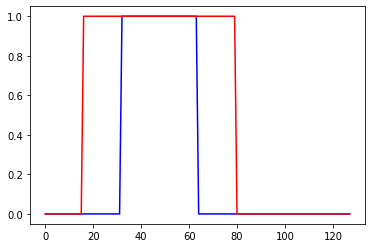

In [69]:
plt.plot(generateTemplate(position = 32, pulse_length=32), 'b')
plt.plot(generateTemplate(position = 16, pulse_length=64), 'r')
plt.show()

add some noise, and maybe shift the position





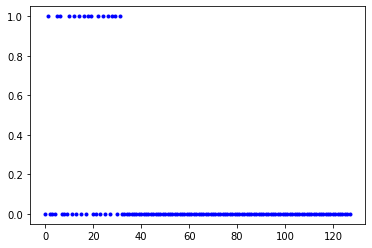

In [70]:
# Plot our data
plt.plot(generateTemplate(noise=0.1), 'b.')
plt.show()

## Create Templates for recognision

Generate a couple of templates, which have a pulse in them, and some without any data

58 19 0.1 60
48 44 2.3 121
63 54 2.8 45
22 54 2.6 123
62 38 2.6 85
24 28 2.0 61
27 55 0.4 41
3 58 1.6 108
9 57 1.6 109
21 58 0.2 36


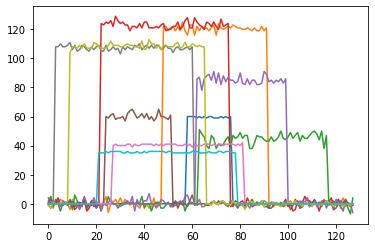

In [71]:
for i in range(10):
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=128-width) # arbitrary position
  noise = np.random.randint(1,30)/10.             # 0.1 to 3 LSB noise
  height = np.random.randint(32,128)              # pulse height of 32 to 128

  print(position, width, noise, height)
  plt.plot(generateTemplate(position = position, pulse_length = width, height=height, noise=noise))

plt.show()

# Building the ANN


### Purpose of the ANN
We want to do Pattern Recognition, based on the waveforms shown above.

The output parameters, which we want to reconstruct are:
*   Width
*   Position
*   height


Starting with importing all things, which we need for creating a model

In [72]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

In [73]:
# number of samples for training, testing etc.
SAMPLES = 10000

## Generate the samples
We want to do Pattern recognition, so we have to link the waveforms to the input parameters.

In [74]:
# use fixed value for noise (1st try)
noise = 0.4 

y_values = []
x_values = []

# generate the waveforms
for i in range(SAMPLES):
  # use random settings
  width = np.random.randint(16, 18)                # width of 16 to 64
  position = np.random.randint(16, high=18)        # arbitrary position
  height = np.random.randint(32,34)                # pulse height of 32 to 128

  x_values.append( (width, position, height) )
  y_values.append( generateTemplate(position = position, pulse_length = width, height=height, noise=noise) )

# debug printouts
#print(x_values[:2])
#print(y_values[:2])

### Look at the training data
Just make a 2D histogram of all templates.

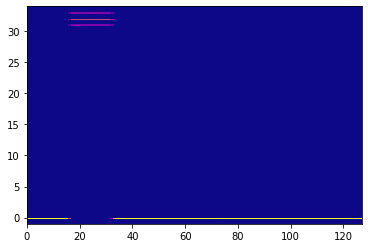

In [75]:
if True:
  plot_x = [ np.arange(128) for i in range(len(y_values)) ]
  plot_x = np.array(plot_x)
  plot_x = plot_x.flatten()
  plot_y = np.array(y_values)
  plot_y = plot_y.flatten()
  plt.hist2d(plot_x, plot_y, bins=128, cmap='plasma')
  plt.show()

## Split the waveforms into Training, Testing and Validation

In [76]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
print("using %d points for training and %d points for testing"%(TRAIN_SPLIT, TEST_SPLIT))

# convert data into numpy arrays
y_values = np.array(y_values) # parameters
x_values = np.array(x_values) # waveforms

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (len(x_train) + len(x_validate) + len(x_test) ) ==  SAMPLES

using 6000 points for training and 8000 points for testing


## Create the ANN

In [95]:
inputs = keras.Input(shape=(128,), name="waveform_input")

layer_cnt=0
x = keras.layers.Dense(128, name="layer_%d"%(layer_cnt))(inputs)
layer_cnt+=1

x = keras.layers.Dense(128, name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(32, name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

x = keras.layers.Dense(64,  name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

# final layer for classification
outputs = keras.layers.Dense(3, name="classification")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform_input (InputLayer)  [(None, 128)]            0         
                                                                 
 layer_0 (Dense)             (None, 128)               16512     
                                                                 
 layer_1 (Dense)             (None, 128)               16512     
                                                                 
 layer_2 (Dense)             (None, 32)                4128      
                                                                 
 layer_3 (Dense)             (None, 64)                2112      
                                                                 
 classification (Dense)      (None, 3)                 195       
                                                                 
Total params: 39,459
Trainable params: 39,459
Non-trainabl

## Train the model

In [96]:
# Train the model on our training data while validating on our validation set
# remember:
#     y = waveforms
#     x = truth parameters
# just do some trainings to see, whether this structure works or not

history_1 = model_1.fit(y_train, x_train, epochs=4, batch_size=128, validation_data=(y_validate, x_validate))

Epoch 1/4
47/47 [==============================] - 1s 8ms/step - loss: 19.5278 - mae: 2.6542 - val_loss: 0.4781 - val_mae: 0.5596
Epoch 2/4
47/47 [==============================] - 0s 6ms/step - loss: 0.1856 - mae: 0.3365 - val_loss: 0.0938 - val_mae: 0.2481
Epoch 3/4
47/47 [==============================] - 0s 5ms/step - loss: 0.0893 - mae: 0.2455 - val_loss: 0.0859 - val_mae: 0.2416
Epoch 4/4
47/47 [==============================] - 0s 6ms/step - loss: 0.0856 - mae: 0.2412 - val_loss: 0.0803 - val_mae: 0.2353


In [97]:
# fully train the network
history_1 = model_1.fit(y_train, x_train, epochs=250, batch_size=128, validation_data=(y_validate, x_validate))

# Save the model to disk
!mkdir -p saved_model
model_1.save('saved_model/STM32_AI_Test')

Epoch 1/250
47/47 [==============================] - 0s 6ms/step - loss: 0.0823 - mae: 0.2369 - val_loss: 0.0831 - val_mae: 0.2378
Epoch 2/250
47/47 [==============================] - 0s 6ms/step - loss: 0.0784 - mae: 0.2332 - val_loss: 0.0754 - val_mae: 0.2306
Epoch 3/250
47/47 [==============================] - 0s 5ms/step - loss: 0.0789 - mae: 0.2336 - val_loss: 0.0835 - val_mae: 0.2376
Epoch 4/250
47/47 [==============================] - 0s 6ms/step - loss: 0.0754 - mae: 0.2294 - val_loss: 0.0778 - val_mae: 0.2327
Epoch 5/250
47/47 [==============================] - 0s 6ms/step - loss: 0.0758 - mae: 0.2295 - val_loss: 0.0720 - val_mae: 0.2270
Epoch 6/250
47/47 [==============================] - 0s 5ms/step - loss: 0.0749 - mae: 0.2284 - val_loss: 0.0740 - val_mae: 0.2284
Epoch 7/250
47/47 [==============================] - 0s 6ms/step - loss: 0.0752 - mae: 0.2286 - val_loss: 0.0762 - val_mae: 0.2317
Epoch 8/250
47/47 [==============================] - 0s 5ms/step - loss: 0.0789 - m

### Evaluate the training performance

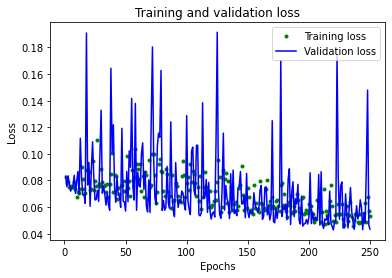

In [98]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:
# evaluate the keras model
_, accuracy = model_1.evaluate(y_validate, x_validate)
print('Accuracy: %.2f' % (accuracy*100))

63/63 [==============================] - 0s 1ms/step - loss: 0.0435 - mae: 0.1834
Accuracy: 18.34


In [100]:
# Test a couple of waveforms
# remember:
#     y = waveforms
#     x = truth parameters

x_test = x_values[1]
y_test = np.array(generateTemplate(position = x_test[0], pulse_length = x_test[1], height=x_test[2], noise=0))

# waveform needs to be reshaped to be fed into ANN
y_test = y_test.reshape(1,128)

# try, whether we can reconstruct the parameters x_test from the waveform y_test
model_1.make_predict_function()
x_test_pred = model_1.predict(y_test)[0]

print("sample pulse created: ", x_test)
print("ANN reconstructed:    ", x_test_pred)

sample pulse created:  [16 16 33]
ANN reconstructed:     [16.37648  16.443018 33.369644]
